In [1]:
from __future__ import division, print_function, absolute_import

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import scipy
from scipy import misc

import skimage
import PIL
from skimage import transform, io
from functools import reduce
from itertools import product

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import fnmatch
import time
import warnings
from joblib import Parallel, delayed

import tensorflow as tf
import keras
from keras.utils import Sequence
from keras import models, layers
from keras.models import Model
from keras.backend import tf as tfk
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.models import load_model, Model
from keras.layers import  LeakyReLU, concatenate, Input, Flatten, Dense, Activation, PReLU, Lambda,\
                          Conv2D, UpSampling2D, add, Lambda, BatchNormalization, Conv2DTranspose
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.optimizers import Adam
import keras.losses

from tqdm import tqdm_notebook as tqdm

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

Using TensorFlow backend.


In [2]:
os.listdir('../dataset/probav_data/')

['train', 'norm.csv', 'test']

In [4]:
# set data directories
train_dir = '../dataset/probav_data/train/'
test_dir = '../dataset/probav_data/test/'
norm_dir = "../dataset/probav_data/norm.csv"
red_train = os.path.join(train_dir, 'RED')
nir_train = os.path.join(train_dir, 'NIR')
red_test = os.path.join(test_dir, 'RED')
nir_test = os.path.join(test_dir, 'NIR')
print("train set: {} RED {} NIR = {} Total".format(len(os.listdir(red_train)),
                                                   len(os.listdir(nir_train)),
                                                   len(os.listdir(red_train))+ len(os.listdir(nir_train))))
print("test set: {} RED {} NIR = {} Total".format(len(os.listdir(red_test)),
                                                   len(os.listdir(nir_test)),
                                                   len(os.listdir(red_test))+ len(os.listdir(nir_test))))
os.listdir(red_train)[:10]

train set: 594 RED 566 NIR = 1160 Total
test set: 146 RED 144 NIR = 290 Total


['imgset0290',
 'imgset0229',
 'imgset0065',
 'imgset0524',
 'imgset0238',
 'imgset0365',
 'imgset0501',
 'imgset0519',
 'imgset0475',
 'imgset0316']

In [139]:
sorted(os.listdir(os.path.join(red_train, 'imgset0323')))

['HR.png',
 'LR000.png',
 'LR001.png',
 'LR002.png',
 'LR003.png',
 'LR004.png',
 'LR005.png',
 'LR006.png',
 'LR007.png',
 'LR008.png',
 'LR009.png',
 'LR010.png',
 'LR011.png',
 'LR012.png',
 'LR013.png',
 'LR014.png',
 'LR015.png',
 'LR016.png',
 'LR017.png',
 'LR018.png',
 'LR019.png',
 'QM000.png',
 'QM001.png',
 'QM002.png',
 'QM003.png',
 'QM004.png',
 'QM005.png',
 'QM006.png',
 'QM007.png',
 'QM008.png',
 'QM009.png',
 'QM010.png',
 'QM011.png',
 'QM012.png',
 'QM013.png',
 'QM014.png',
 'QM015.png',
 'QM016.png',
 'QM017.png',
 'QM018.png',
 'QM019.png',
 'SM.png']

we have two folders, training data and testing data, each one has two folders, one contains the NIR images and the other contains the RED images.<br>
In the training set, for each scene we have one high resolution image (which we need to construct) and several low resolution images. for each image we have a status map that indicates the clear pixels<br>


so let's take a look at the data

In [140]:
image = io.imread(os.path.join(red_train, 'imgset0323', 'HR.png'))
print(image.dtype, image.shape)

uint16 (384, 384)


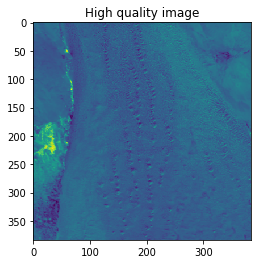

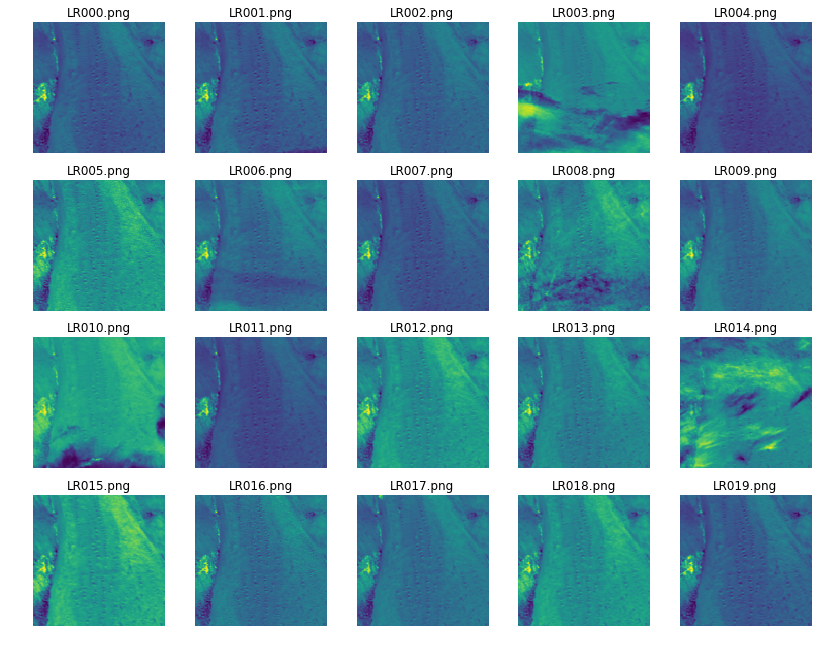

In [141]:
example = 'imgset0323'
hr = io.imread(os.path.join(red_train, example, 'HR.png'))
plt.imshow(hr)
plt.title("High quality image")
fig = plt.figure(figsize=(14, 14))
num_image = len(glob(os.path.join(red_train, example) + '/LR*.png'))
for i, im in enumerate(sorted(glob(os.path.join(red_train, example) + '/LR*.png'))):
    image = io.imread(im)
    ax = fig.add_subplot(num_image/5+1, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(im.split('/')[-1])

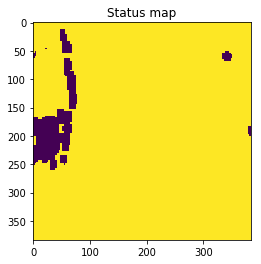

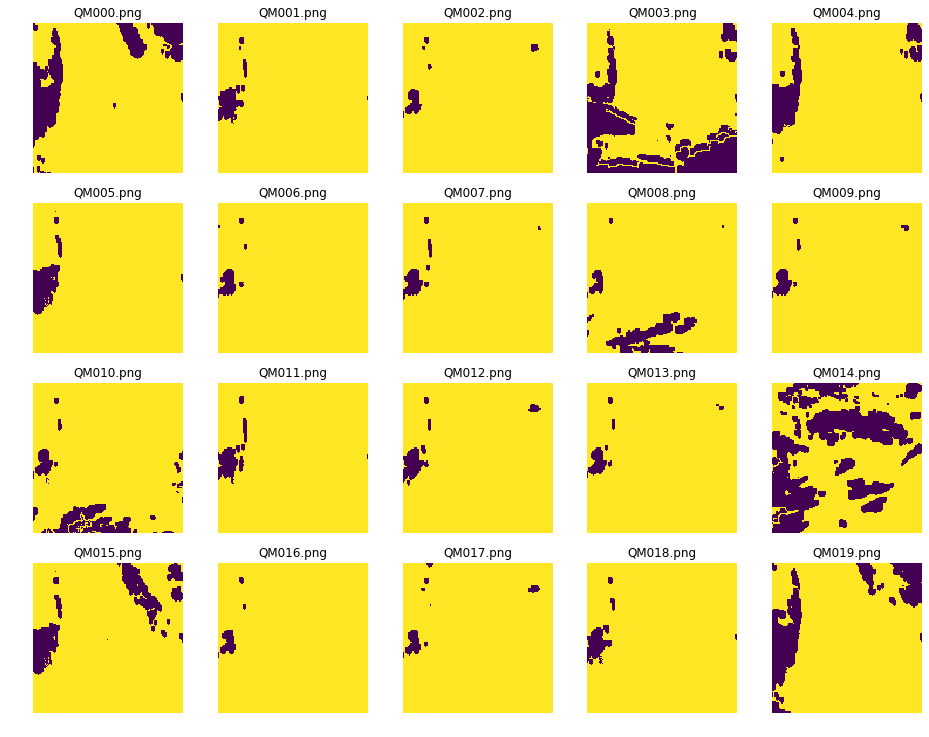

In [142]:
sm = io.imread(os.path.join(red_train, example, 'SM.png'))
plt.imshow(sm)
plt.title("Status map")
fig = plt.figure(figsize=(16, 16))
num_image = len(glob(os.path.join(red_train, example) + '/QM*.png'))
for i, im in enumerate(sorted(glob(os.path.join(red_train, example) + '/QM*.png'))):
    image = io.imread(im)
    ax = fig.add_subplot(num_image/5+1, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(im.split('/')[-1])
    

In [5]:
# norm contains the PSNR of each image for the baseline upscaling
norm = pd.read_csv(norm_dir, names=['file name', 'PSNR'], sep= ' ')
norm.head()

file name       PSNR
0  imgset0000  52.352173
1  imgset0001  46.464812
2  imgset0002  48.646021
3  imgset0003  45.709971
4  imgset0004  52.947346

In [144]:
norm.shape

(1450, 2)

Let's write some helper function to display and compare images

In [6]:
def get_folder(path):
    """list all image path in a folder (train or test)"""
    listing = [os.path.join(path, i, j) for i in ['RED', 'NIR'] for j in os.listdir(os.path.join(path, i))]
    return sorted(listing, key=lambda x: x[-4:])

In [7]:
def read_img(path, extend = True):
    """read an image from path
    if extend = True add a 3rd axis for channel"""
    img = skimage.img_as_float64(io.imread(path).astype(np.uint16))
    if extend:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [8]:
def read_imgs(paths, img_size, extend = True):
    images = np.zeros((len(paths), img_size, img_size, 1))
    for i, path in enumerate(paths):
        images[i, ...] = read_img(path, extend)
    return images

In [9]:
def get_hr(folder_path, extend=False):
    """get the high resolution image with its correspending status map
    """
    # to have value between 0 and 1
    try:
        hr = skimage.img_as_float64(io.imread(folder_path + '/HR.png').astype(np.uint16))
        sm = io.imread(folder_path + '/SM.png').astype(np.bool)
    except FileNotFoundError:
        hr = None
        sm = None
    if extend:
        hr = np.expand_dims(hr, -1)
        sm = np.expand_dims(sm, -1)
    return hr, sm

In [10]:
def get_lr(folder_path, extend=False):
    """generator of low resolution image and its corresponding status map 
    Parameters:
        path : path to the folder containing the images
    Returns:
        generator of a tuple of lr image and status map"""
    for file in glob(folder_path+'/LR*.png'):
        lr = read_img(file, extend = extend)
        QM = file.replace('LR', 'QM')
        qm = io.imread(QM).astype('bool')
        if extend:
            qm = np.expand_dims(qm, -1)
        yield (lr, qm)

In [11]:
train_folds = get_folder(train_dir)
test_folds = get_folder(test_dir)
train_folds[:6]

['../dataset/probav_data/train/RED/imgset0000',
 '../dataset/probav_data/train/RED/imgset0001',
 '../dataset/probav_data/train/RED/imgset0002',
 '../dataset/probav_data/train/RED/imgset0003',
 '../dataset/probav_data/train/RED/imgset0004',
 '../dataset/probav_data/train/RED/imgset0005']

In [151]:
hr, sm = get_hr(train_folds[3])

In [152]:
np.min(hr), np.mean(hr), np.max(hr)

(0.013183794918745708, 0.07108435053523138, 0.16870374608987565)

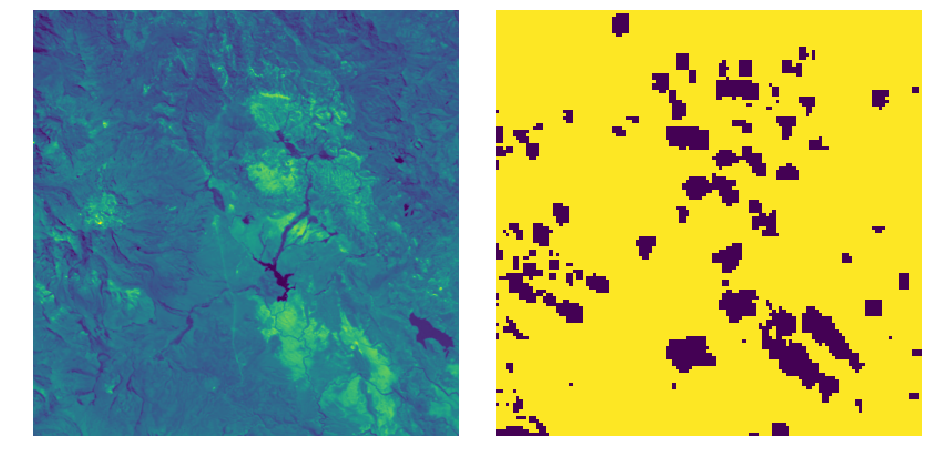

In [153]:
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(121).imshow(hr); plt.axis('off')
ax2 = fig.add_subplot(122).imshow(sm); plt.axis('off')
fig.tight_layout()
fig.show()

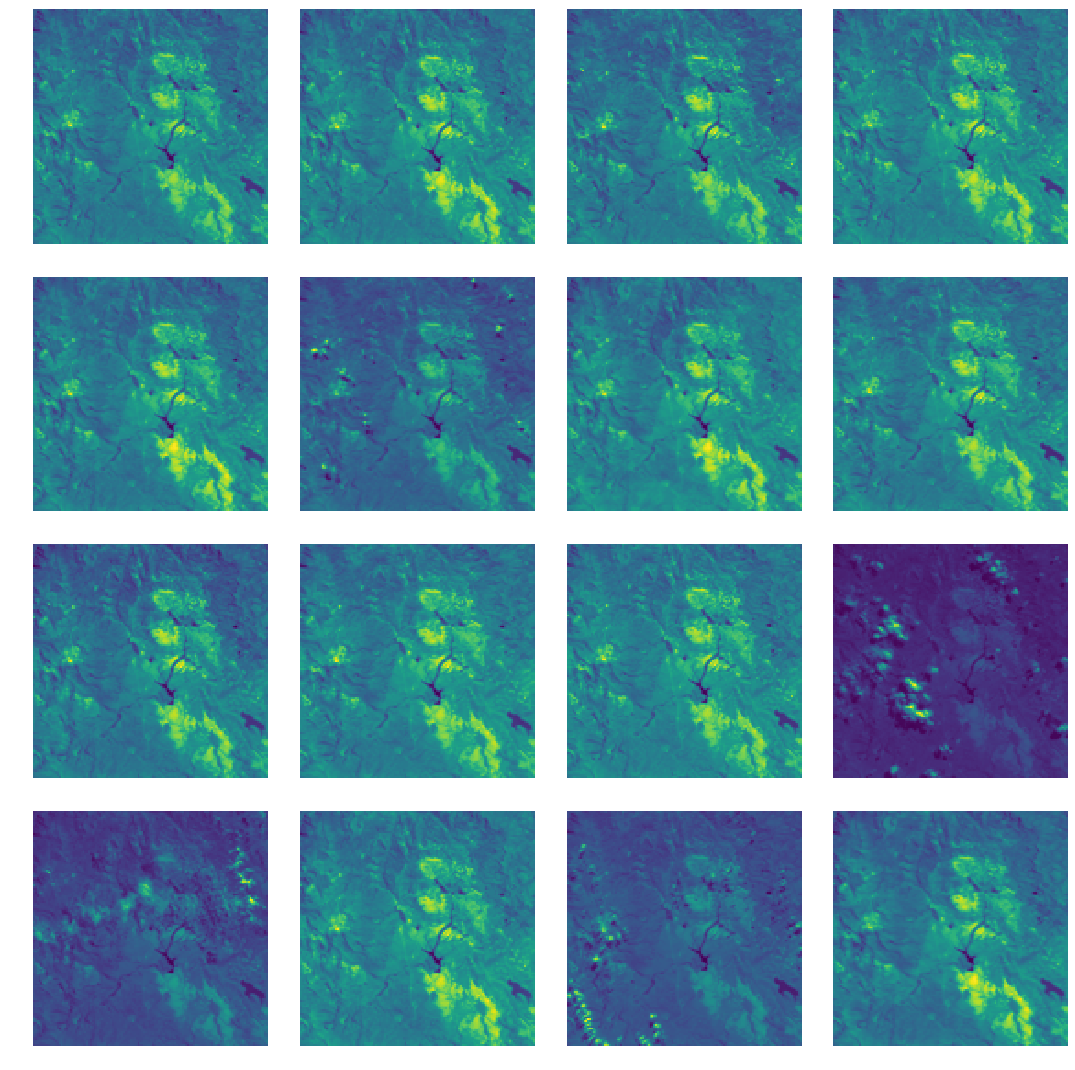

In [154]:
fig = plt.figure(figsize=(15, 15))
for i, (lr, sm) in enumerate(get_lr(train_folds[3])):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(lr)
    plt.axis('off')
    if i == 15:
        break
fig.tight_layout()
fig.show()

The first approach that we will use (and also the simplest one), is to try to construct the HR image by aggregating the LR images<br>
we have many option, for this aggregation, first let's write a function to aggregate the pixels with the mean, median or mode

In [12]:
# we will use the bicubic transformation to upscaling images 
def bicubic_transform(lr, scale=3, order=3,mode = 'edge'):
    """funtion to perform the bicubic transformation
    using skimage library"""
    lr = transform.rescale(lr, scale=scale, order=order, mode=mode, anti_aliasing=False)
    return lr

In [13]:
def baseline_upscale(path, upscale = True):
    
    """this is the function provided by the competition to 
    performe baseline upscalling by averaging picture with maximum clearance"""
    clearance = []
    for file in glob(path + '/QM*.png'):
        qm = io.imread(file).astype('bool')
        clearance.append((np.sum(qm), file[-7:-4]))
    maxcl = max([x[0] for x in clearance])
    maxclears = [x[1] for x in clearance if x[0] == maxcl]

    # upscale and aggregate images with maximum clearance together
    if upscale:
        img = np.zeros( (384, 384), dtype=np.float)
    else:
        img = np.zeros( (128, 128), dtype=np.float)
    for idx in maxclears:
        lrfn = '/LR{}.png'.format(idx)
        lr = read_img(path + lrfn, extend=False)
        # bicubic upscaling
        if upscale:
            img += transform.rescale(lr, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False)
        else:
            img += lr
    img /= len(maxclears)
    return img    

In [14]:
def agg_image(path, agg_fc= 'median', use_sm = True, extend = False):
    
    """combine the LR images by aggregate their pixels
    
    Parameters:
        path:path to the folder of the image
        agg_fc: function to use to aggregate pixels
                it can be one of "mean", "median" and "mode"
                example are np.nanmean, np.nanmax, np.nanmedian, scipy.stats.mode
        use_sm : a boolean parameter to choose whether to use status map or
                to include all pixels
        extend : a boolean parameter to add a 3rd axis or not
    Returns:
        image with 384x384 resolution
    """
    
    agg_opts = {
        'mean'   : lambda i: np.nanmean(i, axis=0),
        'median' : lambda i: np.nanmedian(i, axis=0),
        'mode'   : lambda i: scipy.stats.mode(i, axis=0, nan_policy='omit').mode[0],
        }
    agg = agg_opts[agg_fc]

    lr_sm_list = list(get_lr(path))
    lr_list = []
    lr_nan = []
    for (lr, sm) in lr_sm_list:
        if use_sm:
            temp = lr.copy()
            temp[sm] = np.nan
            lr_nan.append(temp)
            lr[~sm] = np.nan
        lr_list.append(lr)
    agg_img = agg(lr_list)
    if use_sm :
        some_clear = np.isnan(lr_nan).any(axis=0)
        lr_nan= agg(lr_nan)
        lr_nan[some_clear] = 0.0
        np.nan_to_num(agg_img, copy=False)
        agg_img += lr_nan
    if extend:
        agg_img = np.reshape(agg_img, (agg_img.shape[0], agg_img.shape[1], 1))
    return agg_img

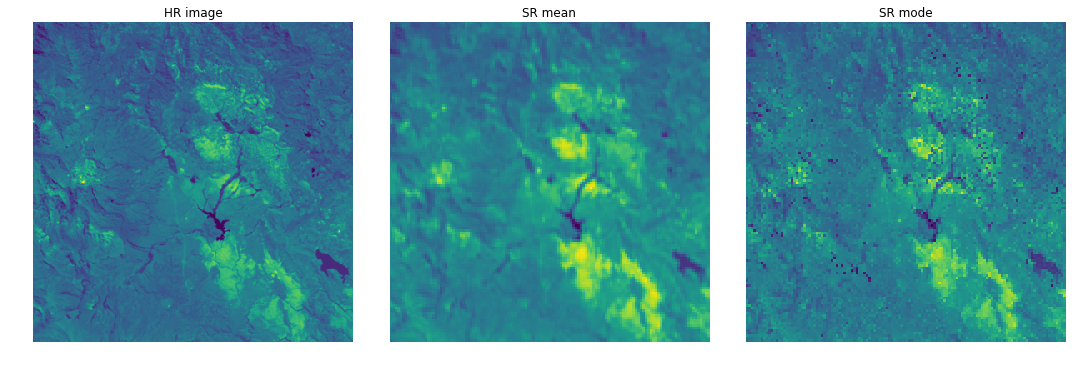

In [158]:
example = train_folds[3]
hr_image,_ = get_hr(example)
sr_image = agg_image(example, "mean", use_sm=False)
sr_image2 = agg_image(example, "mode", use_sm=False)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(131); ax.imshow(hr_image); ax.set_title('HR image');plt.axis('off')
ax = fig.add_subplot(132); ax.imshow(sr_image); ax.set_title('SR mean');plt.axis('off')
ax = fig.add_subplot(133); ax.imshow(sr_image2); ax.set_title('SR mode');plt.axis('off')
fig.tight_layout()
fig.show()

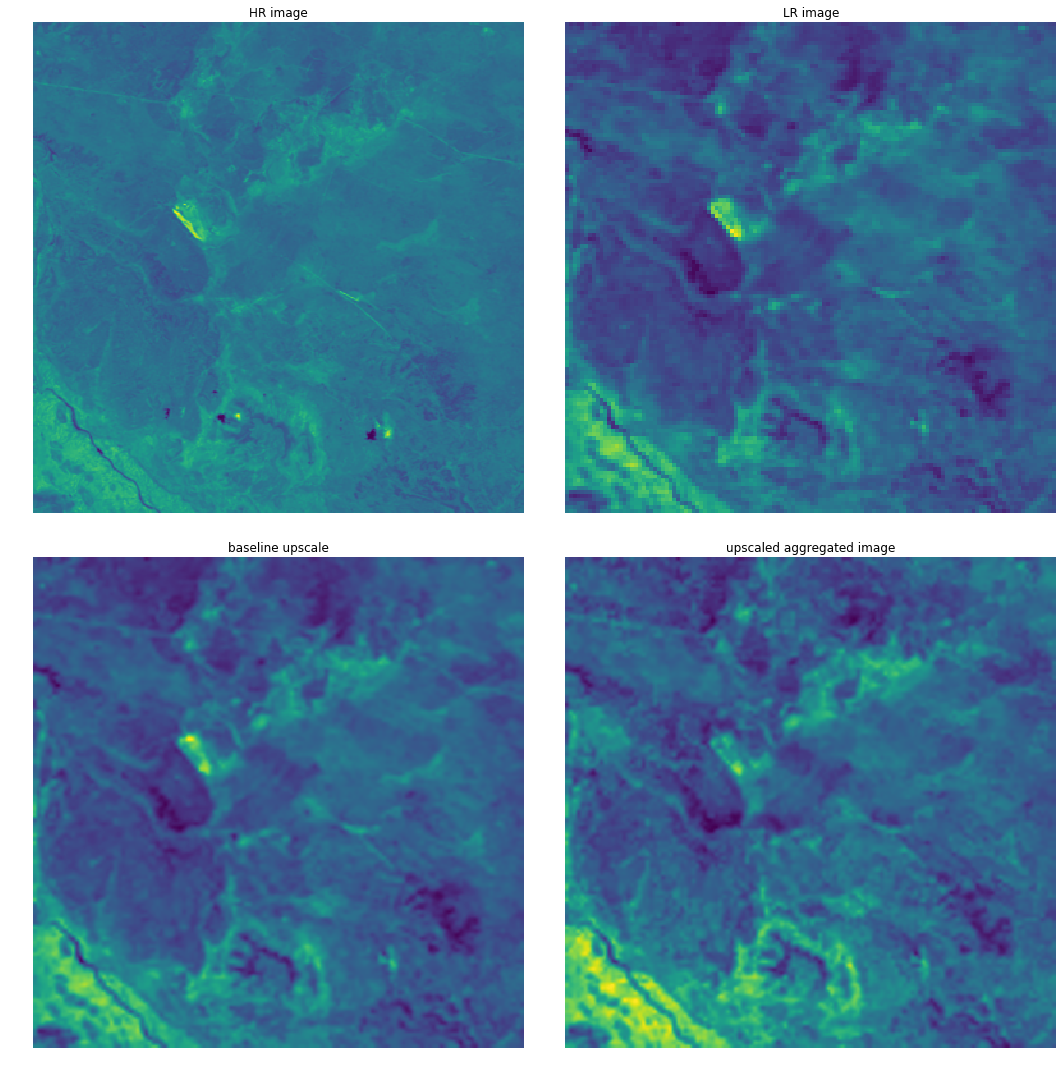

In [159]:
example = train_folds[5]
hr_image,_ = get_hr(example)
lr_image, _ = list(get_lr(example))[1]
upscale_lr_image = baseline_upscale(example)
sr_image = bicubic_transform(agg_image(example, "median", use_sm=True))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image); ax.set_title('HR image');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(lr_image); ax.set_title('LR image');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(upscale_lr_image); ax.set_title('baseline upscale');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image); ax.set_title('upscaled aggregated image');plt.axis('off')
fig.tight_layout()
fig.show()

In [15]:
# in order to compare results, we will write a function 
# to calculate the cPSNR which is the used in th competition 

def cPSNR_image(hr_path, sr, norm_path=norm_dir):
    
    """function to calculate the clear peak signal to noise rate
    it is the metric used in the proba_v competition. This metric uses
    the norm.csv file that contains the baseline cPSNR"""
    
    # see https://kelvins.esa.int/proba-v-super-resolution/scoring/
    if isinstance(sr, str):
        sr = skimage.img_as_float64(io.imread(sr).astype(np.uint16))
    # read the file containing the baseline cPSNR
    norm = pd.read_csv(norm_path, sep=' ', names=['image', 'cPSNR'], index_col='image')
    # transform it to pandas Series
    norm = norm.T.squeeze()
    # we crop the HR image so we should also crop th SR image
    sr_crop = sr[3:-3, 3:-3]
    # list individual score of SR for each u, v in {0, 1, ... , 6}
    z = []
    if hr_path.endswith('.png'):
        hr_path = os.path.dirname(hr_path)
    image_id = hr_path[-10:]
    hr, sm = get_hr(hr_path)
    for u, v in product(range(7), range(7)):
        # crop the image so that its upper left corner at coordinates (u,v)
        # and its lower right corner at (378+u,378+v)
        hr_uv = hr[u:378+u, v:378+v]
        sm_uv = sm[u:378+u, v:378+v]
        b = np.mean(hr_uv[sm_uv] - sr_crop[sm_uv])
        cMSE = np.mean((hr_uv[sm_uv] - sr_crop[sm_uv]-b)**2)
        cPSNR = -10.*np.log10(cMSE)
        z.append(norm[image_id]/cPSNR)
    return np.min(z)        

In [16]:
def cPSNR_images(hr_images, sr_images, norm_path = norm_dir):
    
    """function to calculate the total score of a submission
    Parameters:
        hr_images: list of paths to the HR images, it can be the train folder 
                    path or the test folder
        sr_images: list of sr images or sr path
        norm_path : path to the norm.csv file
    Returns:
        the mean score of all images in images_path
        """
    return  np.mean([cPSNR_image(path_i, sr_i) for path_i, sr_i in zip(hr_images, sr_images)])

In [162]:
for i in range(5):
    example = train_folds[i]
    sr_mean = bicubic_transform(agg_image(example, "mean", use_sm=True))
    sr_median = bicubic_transform(agg_image(example, "median", use_sm=True))
    sr_base = baseline_upscale(example)
    print("image {}: PSNR for mean is {}".format(i, cPSNR_image(example, sr_mean)))
    print("image {}: PSNR for median is {}".format(i, cPSNR_image(example, sr_median)))
    print("image {}: PSNR for baseline is {}".format(i, cPSNR_image(example, sr_base)))

image 0: PSNR for mean is 1.001249990763183
image 0: PSNR for median is 1.0009942718556841
image 0: PSNR for baseline is 1.0000000000000002
image 1: PSNR for mean is 1.0012523915564606
image 1: PSNR for median is 0.9945261552038163
image 1: PSNR for baseline is 0.9999999999999999
image 2: PSNR for mean is 1.0167645734256874
image 2: PSNR for median is 1.0250578577660594
image 2: PSNR for baseline is 0.9999999999999999
image 3: PSNR for mean is 1.0282853065429687
image 3: PSNR for median is 1.0246766050890614
image 3: PSNR for baseline is 0.9999999999999991
image 4: PSNR for mean is 0.99259478741703
image 4: PSNR for median is 0.986741861689131
image 4: PSNR for baseline is 0.9999999999999991


In [163]:
# a bad example compared to baseline
example1 = train_folds[3]
hr_image1,_ = get_hr(example1)
sr_image1 = bicubic_transform(agg_image(example1, "mean", use_sm=False))

# a good example compared to baseline
example2 = train_folds[4]
hr_image2,_ = get_hr(example2)
sr_image2 = bicubic_transform(agg_image(example2, "median", use_sm=True))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image1); ax.set_title('HR image 3');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(sr_image1); ax.set_title('SR mean 3');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(hr_image2); ax.set_title('HR image 4');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image2); ax.set_title('SR median 4');plt.axis('off')
fig.tight_layout()
fig.show()

In [166]:
%%time
# let's apply aggregation with median and upscale with bicubic transformnation
# and calculate the total score on the training set
sr_median_all = [bicubic_transform(agg_image(path_i, agg_fc="median")) for path_i in train_folds]
total_score = np.mean([cPSNR_image(path_i, sr_i) for path_i, sr_i in zip(train_folds, sr_median_all)])
print(total_score)

1.003692235921427
CPU times: user 3min 28s, sys: 1min 55s, total: 5min 23s
Wall time: 3min 44s


In [167]:
del sr_median_all

The upscaled image using median is very close to the baseline upscaling used in the competition<br>
the amount of noise due to upscaling differ from a picture to another,
in general picture with more details are difficult to construct.

Using basic method did not give good result<br>
we will apply machine learning models to tackle this problem<br>


## CNN

first we will try to reconstruct the HR image by using a CNN model that takes as input LR
and outputs the SR image<br>
the labels are the HR images and the loss function is the pixel wise MSE between the SR image and HR image
we will use keras library to construct the neural network<br>

### SRCNN : input baseline upscaled image

We will use the SRCNN, which is a convolutional neural network that maps the bicubic upscaled picture to the HR image.

At first we will combine all images using the baseline upscaling function

In [17]:
LR_IMG_SIZE = 128
HR_IMG_SIZE = 384

In [18]:
np.mean(norm)

PSNR    46.378919
dtype: float64

In [19]:
def PSNR(y_true, y_pred):
    """function to calculate the peak signal to noise rate
    we will used as the loss """
    b = K.mean(y_true - y_pred, axis=(1, 2, 3))
    cMSE = K.mean((y_true - y_pred - b)**2, axis=(1, 2, 3))
    cPSNR = -10.*(K.log(cMSE)/K.log(10.))
    return K.mean(46.37/cPSNR)
    #return cMSE

In [20]:
# so that keras know the loss function when loading the model
keras.losses.PSNR = PSNR

In [21]:
X_train, X_val = train_test_split(train_folds, test_size=0.2, random_state = 123)

In [22]:
def srcnn(lr_dim = 384, channels=1):
    """ Function to construct the SRCNN model"""
    inputs = Input((lr_dim, lr_dim, channels))
    
    x = Conv2D(filters=32, kernel_size=9, activation="relu", padding="same")(inputs)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu',padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu',padding='same')(x)
    x = Conv2D(filters=32, kernel_size=5, activation="relu", padding="same")(x)
    
    out = Conv2D(filters=1, kernel_size=5, padding="same", activation="sigmoid")(x)
    
    return Model(inputs, out)

In [174]:
model = srcnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 384, 384, 1)       0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 384, 384, 32)      2624      
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 384, 384, 32)      9248      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 384, 384, 64)      18496     
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 384, 384, 128)     73856     
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 384, 384, 64)      73792     
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 384, 384, 32)      51232     
__________

In [23]:
class DataGeneratorV1(Sequence):
    """Class to generate batchs of data to use during training"""
    def __init__(self, list_paths, batch_size = 64, 
                 lr_dim=(384,384), hr_dim=(384,384), n_channels=1, shuffle=True, upscale=True):
        'Initialization different parameters'
        self.hr_dim = hr_dim
        self.lr_dim = lr_dim
        self.batch_size = batch_size
        self.list_paths = list_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.upscale = upscale
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'suffle indexes after each epoch'
        self.indexes = np.arange(len(self.list_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def _data_generation(self, list_IDs_temp):
        
        # Initialization
        X = np.empty((self.batch_size, *self.lr_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.hr_dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = baseline_upscale(ID, self.upscale)[..., np.newaxis]
            y[i,], _ = get_hr(ID, extend=True)

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_paths) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_paths[k] for k in indexes]
        # Generate data
        X, y = self._data_generation(list_IDs_temp)

        return X, y

In [24]:
def train(train_data, val_data, arch,checkpoint_path,epochs= 100, loss = 'mse', **kwargs):
    model = arch(**kwargs)
    model.compile(optimizer= 'adam', loss=loss, metrics=['mse'])
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, mode='min')
    model.fit_generator(train_data, epochs=epochs, validation_data = val_data,
                                  callbacks=[checkpoint])
    return model

In [25]:
def predict(generator, arch, checkpoint_path, paths = train_folds,
            out = './predictions/train/', loss = 'mse', **kwargs):
    
    
    model = arch(**kwargs)
    model.load_weights(checkpoint_path)
    model.compile(optimizer= 'adam', loss=loss, metrics=['mse'])
    
    
    sr_path = [out + '/'.join(path.split('/')[-2:]) for path in paths]
    for path in sr_path:
        os.makedirs(path, exist_ok=True)
    X, _ = generator._data_generation(paths)
    # make prediction
    sr = model.predict(X)
    def save_prediction():
        Parallel(n_jobs=10)(delayed(io.imsave)(path + '/SR.png', img) for path, img in zip(sr_path, sr))
    
    # Save prediction
    save_prediction()

In [178]:
srcnn_params = {'hr_dim': (384,384),
          'batch_size': 32,
          'n_channels': 1,
          'shuffle': True}

srcnn_checkpoint_path = './saved_models/srcnn.ckpt'
srcnn_model_params = dict(lr_dim = 384, channels=1)
srcnn_predict_dir = './predictions/srcnn/train/'

In [179]:
for folder in [srcnn_checkpoint_path, srcnn_predict_dir]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [180]:
# training generator and validation generator
train_data = DataGeneratorV1(list_paths = X_train, **srcnn_params)
val_data = DataGeneratorV1(list_paths = X_val, **srcnn_params)

In [ ]:
train(train_data, val_data, srcnn, srcnn_checkpoint_path, epochs=300, loss= PSNR, **srcnn_model_params)

In [181]:
params = {'list_paths': train_folds,
          'batch_size': len(train_folds),
          'shuffle': False}
all_data = DataGeneratorV1(**params)

In [182]:
os.listdir('../input/proba-v-models/')

['fsrcnn_concat_epoch150_psnr.ckpt',
 'fsrcnn_epoch300_agg_mse.ckpt',
 'srcnn_epoch130_psnr.ckpt']

In [183]:
srcnn_model_path = '../input/proba-v-models/srcnn_epoch130_psnr.ckpt'

In [184]:
predict(all_data, srcnn, srcnn_model_path, train_folds, srcnn_predict_dir, loss= PSNR,**srcnn_model_params)

In [209]:
model = srcnn(**srcnn_model_params)
model.load_weights(srcnn_model_path)
model.compile(optimizer= 'adam', loss=PSNR, metrics=['mse'])

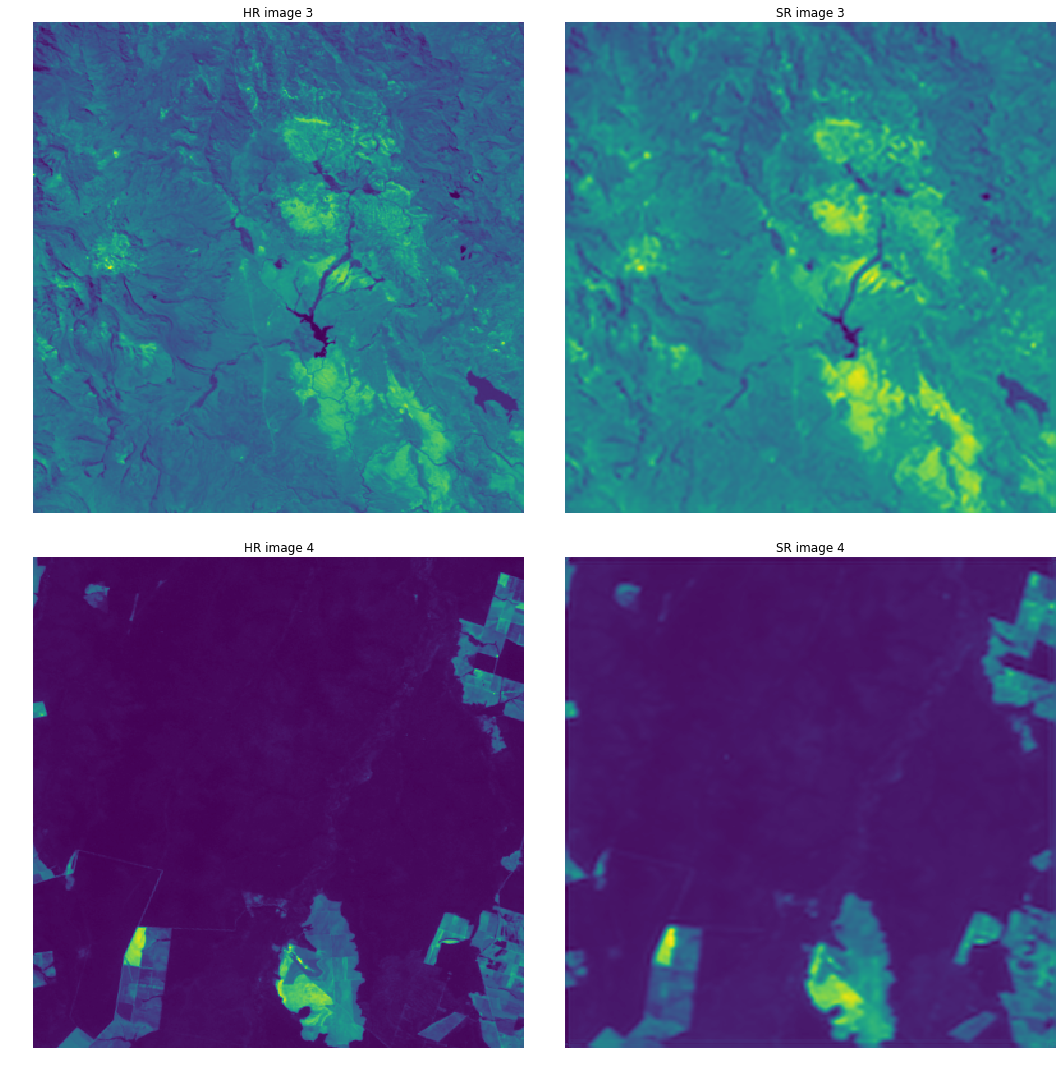

In [214]:
example1 = train_folds[3]
lr_image1 = baseline_upscale(example1)
lr_image1 = lr_image1[np.newaxis, ...]
lr_image1 = lr_image1[..., np.newaxis]
sr_image1 = model.predict(lr_image1)[0,:,:,0]
hr_image1, _ = get_hr(example1)
example2 = train_folds[4]
lr_image2 = baseline_upscale(example2)
lr_image2 = lr_image2[np.newaxis, ...]
lr_image2 = lr_image2[..., np.newaxis]
sr_image2 = model.predict(lr_image2)[0,:,:,0]
hr_image2, _ = get_hr(example2)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image1); ax.set_title('HR image 3');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(sr_image1); ax.set_title('SR image 3');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(hr_image2); ax.set_title('HR image 4');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image2); ax.set_title('SR image 4');plt.axis('off')
fig.tight_layout()
fig.show()

In [187]:
sr_paths = [srcnn_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.225760848270256

### FSRCNN aggregate all LR image 

The trainning was slow and the result were bad<br>
we will implement the FSRCNN which is the Fast super resolution CNN. it is composed of 5 blocks<br>
   - a feature extraction block that extract feature from the low resolution image, it is composed of a Convolutional layer with `d` filters and kernel of size `5x5` 
   - a shrinkage block that is used to reduce the computation complexity of the model, it is composed of one convolution layer with `1x1` kernel and `s` filters such as `s` is smaller than `d`
   - a mapping block that learn the pattern between the LR image and HR image. it is composed of `m` convolution layers with kernel of size `3x3` and `s` filters.
   - an expanding block which invert the process of the shrinkage layer and expand the HR image dimention. It is made of a convolution layer with `d` filters and `1x1` kernel.
   - a deconvolution block that is used to aggregate the previous features and also to upscale the image. it is composed of a deconvolution layer with `1` filter and kernel of size `9x9`

In [26]:
def fsrcnn(d, s, m, channels=1, lr_dim = 128, scale = 3):
    """Function to construct the FSRCNN
    parameters:
        d: number of filters in feature extraction block
        s: number of filters in shrinkage  block
        m: number of layers in mapping block
        channels: the number of channels
        lr_dim: the LR image dimension
        scale: the desired scale"""
    model = keras.Sequential([
        
        # feature extraction block
        layers.Conv2D(filters=d, kernel_size=5, strides=(1,1), padding='same', 
                      input_shape=(lr_dim, lr_dim, channels)),
        layers.PReLU(),
        # shrinkage block
        layers.Conv2D(filters=s, kernel_size=1, strides=(1,1), padding='same'),
        layers.PReLU()] + 

        #mapping block
        [layers.Conv2D(filters=s, kernel_size=3, strides=(1,1), padding='same', activation='elu') for _ in range(m)] + 

        [
            # expanding block
            layers.Conv2D(filters=d, kernel_size=1, strides=(1,1), padding='same'),
            layers.PReLU(),
            # deconvolution block
            layers.Conv2DTranspose(filters=1, kernel_size=9, strides=(scale,scale), 
                                             padding='same')
    ])
    return model

In [27]:
len(X_train)

928

In [28]:
# we will write a data generator class that inherites from Keras Sequence class
# we will use it to generate batchs of images and to apply any kind
# of transformations on the images
class DataGenerator(Sequence):
    def __init__(self, list_paths, batch_size = 64,
                 lr_dim=(128,128), hr_dim=(384,384), n_channels=1, shuffle=True):
        'Initialization different parameters'
        self.lr_dim = lr_dim
        self.hr_dim = hr_dim
        self.batch_size = batch_size
        self.list_paths = list_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'suffle indexes after each epoch'
        self.indexes = np.arange(len(self.list_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def _data_generation(self, list_IDs_temp):
        
        # Initialization
        X = np.empty((self.batch_size, *self.lr_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.hr_dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = agg_image(ID, "median", use_sm=True, extend=True)
            y[i,], _ = get_hr(ID, extend=True)

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_paths) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_paths[k] for k in indexes]
        # Generate data
        X, y = self._data_generation(list_IDs_temp)

        return X, y

In [191]:
params = {'lr_dim': (128,128),
          'hr_dim': (384,384),
          'batch_size': 16,
          'n_channels': 1,
          'shuffle': True}

checkpoint_path = './saved_models/fsrcnn.ckpt'
model_params = dict(d=56, s=12, m=4, channels=1, lr_dim = 128, scale = 3)
predict_dir = './predictions/fsrcnn/train/'

In [192]:
for folder in [checkpoint_path, predict_dir]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [ ]:
train_data = DataGenerator(list_paths = X_train, **params)
val_data = DataGenerator(list_paths = X_val, **params)

In [ ]:
# since I don't have a gpu, I ran it for only 300 epochs
train(train_data, val_data, fsrcnn,checkpoint_path,epochs=300, **model_params)

In [193]:
params = {'list_paths': train_folds,
          'batch_size': len(train_folds),
          'shuffle': False}
all_data = DataGenerator(**params)

In [194]:
fsrcnn_model_path = '../input/proba-v-models/fsrcnn_epoch300_agg_mse.ckpt'

In [195]:
predict(all_data, fsrcnn, fsrcnn_model_path, train_folds, predict_dir, **model_params)

In [215]:
model = fsrcnn(**model_params)
model.load_weights(fsrcnn_model_path)
model.compile(optimizer= 'adam', loss='mse', metrics=['mse'])

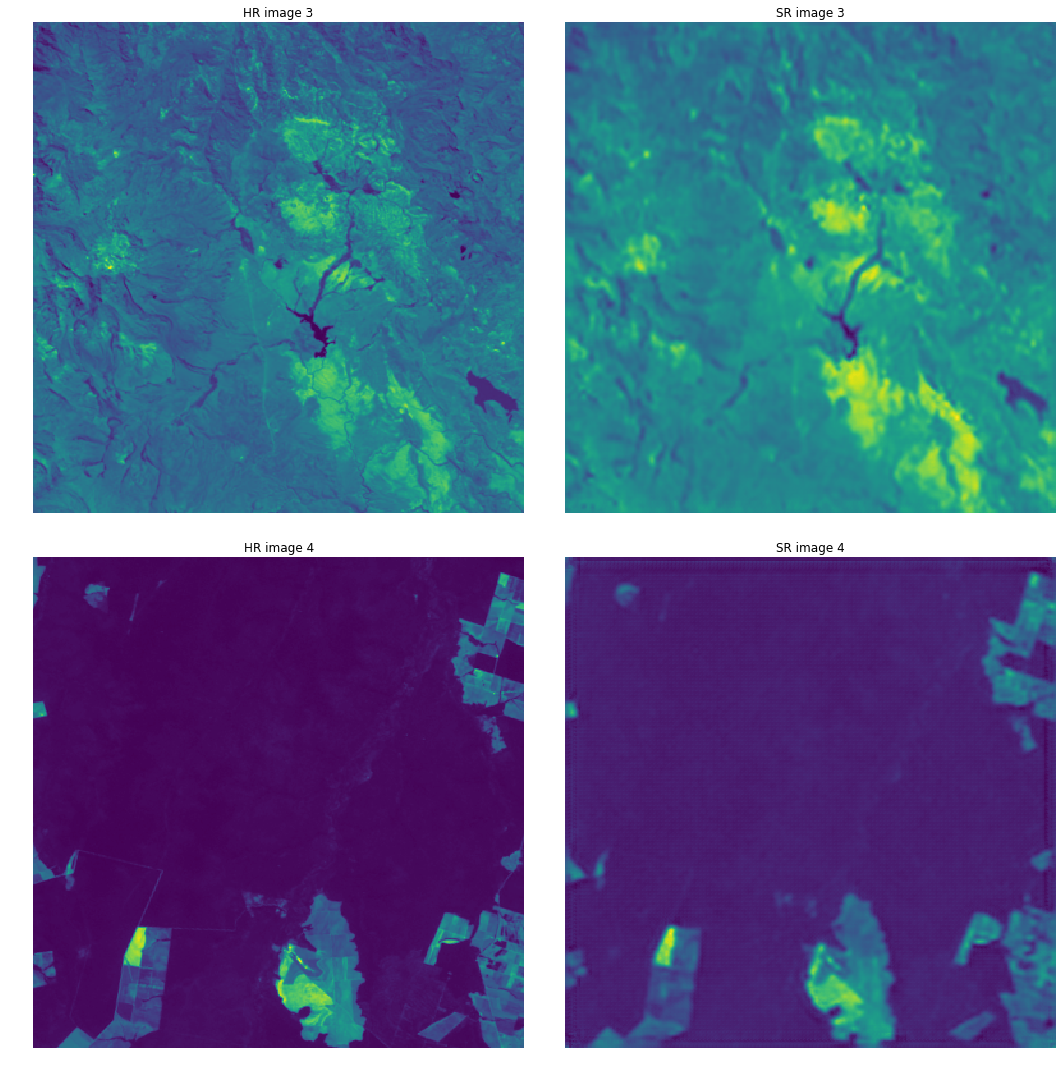

In [217]:
example1 = train_folds[3]
lr_image1 = agg_image(example1, "mean", extend=True)
lr_image1 = lr_image1[np.newaxis, ...]
sr_image1 = model.predict(lr_image1)[0,:,:,0]
hr_image1, _ = get_hr(example1)
example2 = train_folds[4]
lr_image2 = agg_image(example2, "mean", extend=True)
lr_image2 = lr_image2[np.newaxis, ...]
sr_image2 = model.predict(lr_image2)[0,:,:,0]
hr_image2, _ = get_hr(example2)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image1); ax.set_title('HR image 3');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(sr_image1); ax.set_title('SR image 3');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(hr_image2); ax.set_title('HR image 4');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image2); ax.set_title('SR image 4');plt.axis('off')
fig.tight_layout()
fig.show()

In [198]:
sr_paths = [predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.225734880272518

### combine k best images

As we can see the result are bad, next we will use a different loss function which is the PSNR<br>
In the previous model, we aggregate all LR image to predict the HR image. Now we will select the k best images of each scene based on the quality map, and we will multiply each LR image with its corresponding status map and combine them as input to the FSRCNN network

In [199]:
def npPSNR(y_true, y_pred):
    """function to calculate the peak signal to noise rate
    we will used as the loss """
    b = np.mean(y_true - y_pred, axis=(1, 2, 3))
    cMSE = np.mean((y_true - y_pred - b)**2, axis = (1, 2, 3))
    cPSNR = -10*np.log10(cMSE)
    return 46.37/cPSNR

In [29]:
class DataLoader(Sequence):
    def __init__(self, list_paths, lr_dim=(128, 128), hr_dim=(384, 384),
                 n_channels=1, shuffle=True, batch_size=16, concat_size = 9):
        self.lr_dim = lr_dim
        self.hr_dim = hr_dim
        self.batch_size = batch_size
        self.list_paths = list_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.concat_size = concat_size
        self.on_epoch_end()

    def __len__(self):
        return 5*int(np.floor(len(self.list_paths) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def _data_generation(self, list_paths_temp):
        X = np.zeros((self.batch_size, *self.lr_dim, self.concat_size))
        y = np.zeros((self.batch_size, *self.hr_dim, self.n_channels))
        
        for i, fold in enumerate(list_paths_temp):
            lr = [l for l, q in get_lr(fold, extend=True)]
            qm = [q for l, q in get_lr(fold, extend=True)]
            hr, _ = get_hr(fold, extend=True)
            sum_qm = [np.sum(q) for q in qm]
            idx = np.argsort(sum_qm)[-self.concat_size:]
            lr = [lr[i]*qm[i] for i in idx]
            hr = [hr for i in range(self.n_channels)]
            X[i,] = np.concatenate(lr, axis=-1)
            y[i,] = np.concatenate(hr, axis=-1)
        
        return X, y
        
    def __getitem__(self, idx):
        
        indexes = self.indexes[idx*self.batch_size: (idx+1)*self.batch_size]
        
        list_paths_temp = [self.list_paths[k] for k in indexes]
        
        X, y = self._data_generation(list_paths_temp)
        return X, y

In [201]:
concat_generator_params = {'lr_dim': (128,128),
                            'hr_dim': (384,384),
                            'batch_size': 16,
                            'n_channels': 1,
                            'concat_size':9,
                            'shuffle': True}
concat_predict_dir = './predictions/fsrcnn_concat/train/'
concat_checkpoint_path = './saved_models/fsrcnn_concat.ckpt'
concat_model_params = dict(d=56, s=12, m=4, channels=9, lr_dim = 128, scale = 3)

train_data = DataLoader(list_paths = X_train, **concat_generator_params)
val_data = DataLoader(list_paths = X_val, **concat_generator_params)

In [202]:
for folder in [concat_predict_dir, concat_checkpoint_path, concat_model_path]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [ ]:
train(train_data, val_data, fsrcnn, concat_checkpoint_path, concat_model_path, epochs=300, loss=PSNR,**concat_model_params)

In [203]:
params = {'lr_dim': (128,128),
            'hr_dim': (384,384),
            'batch_size': len(train_folds),
            'n_channels': 1,
            'concat_size':9,
            'shuffle': True}
all_data = DataLoader(list_paths = train_folds, **params)

In [204]:
concat_model_path = '../input/proba-v-models/fsrcnn_concat_epoch150_psnr.ckpt'

In [205]:
predict(all_data, fsrcnn, concat_model_path, train_folds, concat_predict_dir, loss=PSNR,**concat_model_params)

In [206]:
sr_paths = [concat_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.2179047343294864

In [218]:
model = fsrcnn(**concat_model_params)
model.load_weights(concat_model_path)
model.compile(optimizer= 'adam', loss=PSNR, metrics=['mse'])

In [219]:
batch_data = DataLoader(list_paths = train_folds, shuffle=False, batch_size=2)
lr_img, hr_img = batch_data[0]
sr_image = model.predict(lr_img)
fig = plt.figure(figsize=(20, 20))
for i in range(2):
    ax = fig.add_subplot(2, 2, i*2+1); ax.imshow(hr_img[i,:,:,0]); ax.set_title('HR image'); plt.axis('off')
    ax = fig.add_subplot(2, 2, i*2+2); ax.imshow(sr_image[i, :,:,0]); ax.set_title('SR image {:.6f}'.format(np.mean(np.square(hr_image - sr_image))));
    plt.axis('off')
fig.tight_layout()
fig.show()   

## ESRGAN

Next we will use a modified version of the Super Resolution Generative Adversarial Network by Xintao and al. It is a GAN that is capable of generating realistic textures for super resolution. ESRGAN is used for single image resolution, we will apply it to our problem which is a multi-image super resolution by combine top clearer pictures 

In [2]:
def reset_keras():
    """function to free up memory"""
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    print(gc.collect())

In [31]:
class ESRGAN():
    """Class to consteuct the ESRGAN model"""
    def __init__(self, lr_shape, hr_shape, scale, nf):
        self.lr_shape = lr_shape
        self.hr_shape = hr_shape
        self.scale = scale
        self.nf = nf
        
    def RDB(self, x):
        """Function that implement the residual dense 
        block which is the basic block of ESRGAN"""
        x1 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x))
        x2 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1])))
        #x3 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1, x2])))
        #x4 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1, x2, x3])))
        x5 = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1, x2]))
        x5 = layers.Lambda(lambda x: x*0.2)(x5)
        return add([x5, x])
    
    def RB(self, x):
        """Function that implement the residual  
        block which is the basic block of SRGAN"""
        x1 = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x)
        x1 = BatchNormalization(momentum=0.5)(x1)
        x1 = LeakyReLU(0.2)(x1)
        
        x1 = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x1)
        x1 = BatchNormalization(momentum=0.5)(x1)
        
        return add([x1, x])
    
    def upsampling(self, x, scale):
        x = Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
        x = UpSampling2D(scale)(x)
        x = LeakyReLU(0.2)(x)
        return x
    
    def RRDB(self, x):
        """Function that implement the residual in residual dense 
        block which is conposed of three RDB"""
        y = self.RDB(x)
        y = self.RDB(y)
        y = self.RDB(y)
        y = layers.Lambda(lambda x: x*0.2)(y)
        return add([y, x])
        
    def Generator(self):
        inputs = Input(shape=(self.lr_shape[0], self.lr_shape[1], 3))
        x = Conv2D(filters=self.nf, kernel_size=9, strides=1, padding='same')(inputs)
        x = LeakyReLU(0.2)(x)
        x1 = x
        # this one used in case of ESRGAN
        x = self.RRDB(x)
        # this one used in case of SRGAN
        # for _ in range(4):  
        #    x = self.RB(x)  # 
        x = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x)
        x = concatenate([x, x1])
        x = self.upsampling(x, self.scale)
        x = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
        gen = Model(inputs = inputs, outputs = x)
        return gen
    
    def Discriminator(self):
        
        def basic_block(x, k, n, s):
            x = Conv2D(kernel_size=k, filters=n, strides=s, padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(0.2)(x)
            return x
        
        inputs = Input(shape=(self.hr_shape[0], self.hr_shape[1], 3))
        x = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(inputs)
        x = LeakyReLU(0.2)(x)
        
        x = basic_block(x, 4, self.nf, 2)
        x = basic_block(x, 4, self.nf*2, 1)
        x = basic_block(x, 4, self.nf*2, 2)
        x = basic_block(x, 4, self.nf*4, 1)
        x = basic_block(x, 4, self.nf*4, 2)
        x = basic_block(x, 4, self.nf*8, 1)
        x = basic_block(x, 4, self.nf*8, 2)
        #x = basic_block(x, 3, self.nf*4, 2)
        
        x = Flatten()(x)
        x = Dense(1024)(x)
        x = LeakyReLU(0.2)(x)
        x = Dense(1, activation='sigmoid')(x)
        
        des = Model(inputs= inputs, outputs = x)
        
        return des


def process_vgg(x):
    # transform image from [0,1] to [0, 255]
    x *= 255
    x = x[..., ::-1]
    # imagenet mean
    mean = [103.939, 116.778, 123.68]
    imagenet_mean = K.constant(-np.array(mean))
    x = K.bias_add(x, K.cast(imagenet_mean, K.dtype(x)))
    return x

def vgg_loss(y_true, y_pred):
    """content loss"""
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(HR_IMG_SIZE, HR_IMG_SIZE, 3))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    model.trainable = False
    return 0.006*K.mean(K.square(model(process_vgg(y_true)) - model(process_vgg(y_pred))))
    
def create_gan(discriminator, generator, shape, vgg_loss):
    """create a gan model with a discriminator and a generator"""
    discriminator.trainable = False
    input_generator_gan = Input(shape=shape)
    output_generator_gan = generator(input_generator_gan)
    output_discriminator_gan = discriminator(output_generator_gan)
    gan = Model(inputs=input_generator_gan, outputs=[output_generator_gan,output_discriminator_gan])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=Adam(lr=1e-4, beta_1=0.9))
    return gan

In [40]:
keras.losses.vgg_loss = vgg_loss

In [41]:
def train_gan(train_data, val_data, epochs, model_path, scale=3, nf=64):
    esrgan = ESRGAN(train_data.lr_dim, train_data.hr_dim, scale, nf)
    
    generator = esrgan.Generator()
    discriminator = esrgan.Discriminator()
    
    generator.compile(optimizer = Adam(lr=1e-4, beta_1=0.9), loss = vgg_loss)
    discriminator.compile(optimizer = Adam(lr=1e-4, beta_1=0.9), loss = "binary_crossentropy")
    
    gan = create_gan(discriminator, generator, esrgan.lr_shape+(3,), vgg_loss)
    
    d_loss = []
    list_g_loss_vgg = []
    list_g_loss_crentropy = []
    
    for epoch in range(1, epochs+1):
        epoch_start = time.time()
        
        print("Epoch {}/{}".format(epoch, epochs))
        
        for i in tqdm(range(len(train_data)//2)):
            
            #generate data 
            start = time.time()
            lr_image, hr_image = train_data[i*2]
            sr_image = generator.predict(lr_image)
            #print("predict generator %f s" %(time.time()-start))
            
            # Train Discriminator on generated image
            start = time.time()
            discriminator.trainable = True
            fake_label = np.random.uniform(0.0, 0.3, size=(sr_image.shape[0]))
            d_loss_fake = discriminator.train_on_batch(sr_image, fake_label)
            #print("train discriminator on fake %f s" %(time.time()-start))
            
            # Train Discriminator on real image
            start = time.time()
            real_label = np.random.uniform(0.7, 1.2, size=(hr_image.shape[0]))
            d_loss_real = discriminator.train_on_batch(hr_image, real_label)
            d_loss.append(d_loss_real + d_loss_fake)
            #print("train discriminator or real %f s" %(time.time()-start))
            
            # Train Generator
            start = time.time()
            discriminator.trainable = False
            lr_image, hr_image = train_data[i*2+1]
            gan_label = np.ones(lr_image.shape[0])- np.random.random_sample(lr_image.shape[0])*0.2
            gan_loss = gan.train_on_batch(lr_image, [hr_image, gan_label])
            list_g_loss_vgg.append(gan_loss[0])
            list_g_loss_crentropy.append(gan_loss[1])
            #print("train generator %f s" %(time.time()-start))
            gc.collect()
            
        
        print("discriminator {}".format(np.mean(d_loss[-len(train_data):])))
        print("gan vgg loss : {} - gan cross_entropy loss : {}".format(np.mean(list_g_loss_vgg[-len(train_data):]),
                                                                       np.mean(list_g_loss_crentropy[-len(train_data):])))
        print("Epoch {} finished in {}".format(epoch, time.time()-epoch_start))
        evaluate_generator(generator, val_data)
        if epoch % 1 == 0:
            generator.save(model_path + 'gen_model{}.h5'.format(epoch))
            #discriminator.save(model_path + 'dis_model{}.h5'.format(epoch))

In [42]:
def evaluate_generator(generator, data):
    lr_image, hr_image = data[0]
    sr_image = generator.predict(lr_image)
    mse = np.mean((sr_image- hr_image)**2)
    print("val_mse: {} - val_PSNR: {}".format(mse, npPSNR(hr_image, sr_image)))

In [43]:
gan_generator_params = {'lr_dim': (128,128),
                            'hr_dim': (384,384),
                            'n_channels': 3,
                            'concat_size':3,
                            'shuffle': True}
gan_predict_dir = './predictions/gan/train/'
gan_checkpoint_path = './saved_models/gan/'
gan_model_params = dict(lr_shape=(128,128), hr_shape = (384,384), scale = 3, nf= 16)
train_data = DataLoader(list_paths = X_train, batch_size= 8, **gan_generator_params)
val_data = DataLoader(list_paths = X_val, batch_size= 1, **gan_generator_params)

In [44]:
for folder in [gan_predict_dir, gan_checkpoint_path]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [ ]:
train_gan(train_data, val_data, epochs=100, model_path=gan_checkpoint_path)

In [45]:
gan_model_path = './trained models/gen_model.h5'

In [59]:
generator = models.load_model(gan_model_path)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
all_data = DataLoader(list_paths = train_folds, batch_size= len(train_folds), **gan_generator_params)

In [ ]:
sr_path = [gan_predict_dir + '/'.join(path.split('/')[-2:]) for path in train_folds]
for path in sr_path:
    os.makedirs(path, exist_ok=True)
X, _ = all_data._data_generation(train_folds)
# make prediction
sr = generator.predict(X)[:,:,:,0]
def save_prediction():
    Parallel(n_jobs=10)(delayed(io.imsave)(path + '/SR.png', img) for path, img in zip(sr_path, sr))

# Save prediction
save_prediction()

In [64]:
sr_paths = [gan_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.2255353746530138

### LapSRN

In [1]:
def feature_embedding(filters, conv_num): 
    inputs = Input(shape=(None, None, filters))
    
    x = LeakyReLU(0.2)(inputs)
    x = Conv2D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    for _ in range(conv_num-1):
        x = LeakyReLU(0.2)(x)
        x = Conv2D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

def upsample_and_condense(x, filters):

    x = LeakyReLU(0.2)(x)
    upsample = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(upsample)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    condense = Conv2D(1, kernel_size=3, padding='same', use_bias=False)(x)
    return condense, upsample

def residual_block(recursive_num, filters, conv_num):

    embedding = feature_embedding(filters, conv_num)
    inputs = Input(shape=(None, None, filters))
    x = embedding(inputs)
    x = Add()([x, inputs])
    for _ in range(recursive_num-1):
        x = embedding(x)
        x = Add()([x, inputs])
    res, upsample = upsample_and_condense(x)
    model = Model(inputs=inputs, outputs=[res, upsample])
    return model

def upsample_block(filters):

    img_input = Input(shape=(None, None, 1))
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(img_input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    upsample = Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    model = Model(inputs=img_input, outputs=upsample)
    return model

def conv_block(filters):
    
    img_input = Input(shape=(None, None, 1))
    
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(img_input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    output = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    
    model = Model(inputs=img_input, outputs=output)
    return model

def lapsrn(lr_dim, hr_dim, filters = 32, conv_num = 5, recursive_num = 3):
    
    conv = conv_block(filters)
    residual = residual_block(recursive_num, filters, conv_num)
    upsample = upsample_block(filters)

    inputs = Input(shape=(lr_dim, lr_dim, 1))
    
    # X2
    conv_1 = conv(inputs)
    upsample_1 = upsample(inputs)
    residual_1, f_upsample_1 = residual(conv_1)
    hr1 = Add()([upsample_1, residual_1])
    
    #X4
    upsample_2 = upsample(hr1)
    residual_2, f_upsample_2 = residual(f_upsample_1)
    hr2 = Add()([upsample_2, residual_2])
    
    #X3
    hr2 = Lambda(lambda img: tfk.image.resize_images(img, (hr_dim, hr_dim)))(hr2)
    model = Model(inputs=inputs, outputs=hr2)

    return model

In [ ]:
reset_keras()

In [47]:
model = lapsrn(128, 384)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
init_embedd (Model)             multiple             27936       input_5[0][0]                    
__________________________________________________________________________________________________
upsample (Model)                multiple             10016       input_5[0][0]                    
                                                                 add_4[0][0]                      
__________________________________________________________________________________________________
model_2 (Model)                 multiple             81184       init_embedd[1][0]                
          

In [ ]:
def charbonnier_loss(y_true, y_pred):
    eps = 1e-3
    diff = y_true - y_pred
    error = K.sqrt( diff * diff + eps**2 )
    loss = K.sum(error) 
    return loss

def adj_learning_rate(optimizer, epoch):
    lr = 0.00001 * (0.1 ** (epoch // 10))
    return lr

#### Charbonnier Loss

In [ ]:
lapsrn_generator_params = {'lr_dim': (128,128),
                            'hr_dim': (384,384),
                            'n_channels': 1,
                           'upscale': False,
                            'shuffle': True}
lapsrn_predict_dir = './predictions/lapsrn/train/'
lapsrn_checkpoint_path = './saved_models/lapsrn/lapsrn.ckpt'
lapsrn_model_params = dict(lr_shape=(128,128), hr_shape = (384,384))
train_data = DataGeneratorV1(list_paths = X_train, batch_size= 16, **lapsrn_generator_params)
val_data = DataGeneratorV1(list_paths = X_val, batch_size= 1, **lapsrn_generator_params)

In [ ]:
folder = os.path.dirname(lapsrn_checkpoint_path)
os.makedirs(folder, exist_ok=True)

In [ ]:
model.compile(optimizer='adam', loss=charbonnier_loss, metrics=[PSNR])
lrsh=LearningRateScheduler(adj_learning_rate)
checkpoint = ModelCheckpoint(lapsrn_checkpoint_path, save_best_only=True)
history = model.fit_generator(train_data, validation_data = val_data,epochs=500, verbose=0, callbacks=[checkpoint, lrsh])

In [40]:
model = lapsrn(128, 384)
model.compile(optimizer='adam', loss=charbonnier_loss, metrics=[PSNR])
model.load_weights(srn_model_path)

In [48]:
all_data = DataGeneratorV1(list_paths = train_folds, batch_size= len(train_folds), **lapsrn_generator_params)

In [54]:
sr_path = [lapsrn_predict_dir + '/'.join(path.split('/')[-2:]) for path in train_folds]
for path in sr_path:
    os.makedirs(path, exist_ok=True)
X, _ = all_data._data_generation(train_folds)
# make prediction
sr = model.predict(X)[:,:,:,0]
def save_prediction():
    Parallel(n_jobs=10)(delayed(io.imsave)(path + '/SR.png', img) for path, img in zip(sr_path, sr))

# Save prediction
save_prediction()

In [57]:
sr_paths = [lapsrn_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.2257797533555719

#### PSNR Loss

In [ ]:
lapsrn2_predict_dir = './predictions/lapsrn2/train/'
lapsrn2_checkpoint_path = './saved_models/lapsrn2/lapsrn2.ckpt'

In [ ]:
folder = os.path.dirname(lapsrn2_checkpoint_path)
os.makedirs(folder, exist_ok=True)

In [57]:
model = lapsrn(128, 384)
model.compile(optimizer='adam', loss=PSNR, metrics=[PSNR])
lrsh=LearningRateScheduler(adj_learning_rate)
checkpoint = ModelCheckpoint(lapsrn2_checkpoint_path, save_best_only=True)
history = model.fit_generator(train_data, validation_data = val_data,epochs=600, verbose=0, callbacks=[checkpoint, lrsh])

Epoch 1/600
58/58 [==============================] - 54s 940ms/step - loss: 1.1533 - PSNR: 1.1533 - val_loss: 1.0410 - val_PSNR: 1.0410
Epoch 2/600
58/58 [==============================] - 48s 828ms/step - loss: 1.1592 - PSNR: 1.1592 - val_loss: 1.0490 - val_PSNR: 1.0490
Epoch 3/600
58/58 [==============================] - 48s 829ms/step - loss: 1.1541 - PSNR: 1.1541 - val_loss: 1.0383 - val_PSNR: 1.0383
Epoch 4/600
58/58 [==============================] - 47s 802ms/step - loss: 1.1629 - PSNR: 1.1629 - val_loss: 1.0470 - val_PSNR: 1.0470
Epoch 5/600
58/58 [==============================] - 44s 766ms/step - loss: 1.1574 - PSNR: 1.1574 - val_loss: 1.0393 - val_PSNR: 1.0393
Epoch 6/600
58/58 [==============================] - 43s 736ms/step - loss: 1.1524 - PSNR: 1.1524 - val_loss: 1.0356 - val_PSNR: 1.0356
Epoch 7/600
58/58 [==============================] - 42s 731ms/step - loss: 1.1545 - PSNR: 1.1545 - val_loss: 1.0414 - val_PSNR: 1.0414
Epoch 8/600
58/58 [=============================

Epoch 61/600
58/58 [==============================] - 42s 727ms/step - loss: 1.1333 - PSNR: 1.1333 - val_loss: 1.0554 - val_PSNR: 1.0554
Epoch 62/600
58/58 [==============================] - 42s 718ms/step - loss: 1.1453 - PSNR: 1.1453 - val_loss: 1.0571 - val_PSNR: 1.0571
Epoch 63/600
58/58 [==============================] - 42s 720ms/step - loss: 1.1346 - PSNR: 1.1346 - val_loss: 1.0508 - val_PSNR: 1.0508
Epoch 64/600
58/58 [==============================] - 41s 702ms/step - loss: 1.1266 - PSNR: 1.1266 - val_loss: 1.0428 - val_PSNR: 1.0428
Epoch 65/600
58/58 [==============================] - 41s 705ms/step - loss: 1.1370 - PSNR: 1.1370 - val_loss: 1.0468 - val_PSNR: 1.0468
Epoch 66/600
58/58 [==============================] - 41s 700ms/step - loss: 1.1300 - PSNR: 1.1300 - val_loss: 1.0544 - val_PSNR: 1.0544
Epoch 67/600
58/58 [==============================] - 41s 704ms/step - loss: 1.1249 - PSNR: 1.1249 - val_loss: 1.0553 - val_PSNR: 1.0553
Epoch 68/600
58/58 [=====================

58/58 [==============================] - 40s 695ms/step - loss: 1.0645 - PSNR: 1.0645 - val_loss: 1.0752 - val_PSNR: 1.0752
Epoch 180/600
58/58 [==============================] - 40s 698ms/step - loss: 1.0566 - PSNR: 1.0566 - val_loss: 1.0721 - val_PSNR: 1.0721
Epoch 181/600
58/58 [==============================] - 40s 696ms/step - loss: 1.0580 - PSNR: 1.0580 - val_loss: 1.0668 - val_PSNR: 1.0668
Epoch 182/600
58/58 [==============================] - 40s 694ms/step - loss: 1.0578 - PSNR: 1.0578 - val_loss: 1.0608 - val_PSNR: 1.0608
Epoch 183/600
58/58 [==============================] - 42s 716ms/step - loss: 1.0584 - PSNR: 1.0584 - val_loss: 1.0659 - val_PSNR: 1.0659
Epoch 184/600
58/58 [==============================] - 40s 695ms/step - loss: 1.0587 - PSNR: 1.0587 - val_loss: 1.0579 - val_PSNR: 1.0579
Epoch 185/600
58/58 [==============================] - 40s 694ms/step - loss: 1.0572 - PSNR: 1.0572 - val_loss: 1.0705 - val_PSNR: 1.0705
Epoch 186/600
58/58 [===========================

58/58 [==============================] - 41s 705ms/step - loss: 1.0441 - PSNR: 1.0441 - val_loss: 1.0679 - val_PSNR: 1.0679
Epoch 298/600
58/58 [==============================] - 41s 708ms/step - loss: 1.0425 - PSNR: 1.0425 - val_loss: 1.0673 - val_PSNR: 1.0673
Epoch 299/600
58/58 [==============================] - 42s 717ms/step - loss: 1.0447 - PSNR: 1.0447 - val_loss: 1.0652 - val_PSNR: 1.0652
Epoch 300/600
58/58 [==============================] - 42s 719ms/step - loss: 1.0429 - PSNR: 1.0429 - val_loss: 1.0711 - val_PSNR: 1.0711
Epoch 301/600
58/58 [==============================] - 41s 703ms/step - loss: 1.0458 - PSNR: 1.0458 - val_loss: 1.0602 - val_PSNR: 1.0602
Epoch 302/600
58/58 [==============================] - 40s 698ms/step - loss: 1.0400 - PSNR: 1.0400 - val_loss: 1.0681 - val_PSNR: 1.0681
Epoch 303/600
58/58 [==============================] - 40s 694ms/step - loss: 1.0454 - PSNR: 1.0454 - val_loss: 1.0522 - val_PSNR: 1.0522
Epoch 304/600
58/58 [===========================

58/58 [==============================] - 41s 703ms/step - loss: 1.0372 - PSNR: 1.0372 - val_loss: 1.0649 - val_PSNR: 1.0649
Epoch 416/600
58/58 [==============================] - 40s 693ms/step - loss: 1.0373 - PSNR: 1.0373 - val_loss: 1.0699 - val_PSNR: 1.0699
Epoch 417/600
58/58 [==============================] - 40s 695ms/step - loss: 1.0370 - PSNR: 1.0370 - val_loss: 1.0679 - val_PSNR: 1.0679
Epoch 418/600
58/58 [==============================] - 40s 686ms/step - loss: 1.0415 - PSNR: 1.0415 - val_loss: 1.0675 - val_PSNR: 1.0675
Epoch 419/600
58/58 [==============================] - 40s 694ms/step - loss: 1.0423 - PSNR: 1.0423 - val_loss: 1.0628 - val_PSNR: 1.0628
Epoch 420/600
58/58 [==============================] - 40s 697ms/step - loss: 1.0437 - PSNR: 1.0437 - val_loss: 1.0711 - val_PSNR: 1.0711
Epoch 421/600
58/58 [==============================] - 41s 705ms/step - loss: 1.0466 - PSNR: 1.0466 - val_loss: 1.0697 - val_PSNR: 1.0697
Epoch 422/600
58/58 [===========================

58/58 [==============================] - 41s 701ms/step - loss: 1.0465 - PSNR: 1.0465 - val_loss: 1.0675 - val_PSNR: 1.0675
Epoch 534/600
58/58 [==============================] - 41s 708ms/step - loss: 1.0391 - PSNR: 1.0391 - val_loss: 1.0621 - val_PSNR: 1.0621
Epoch 535/600
58/58 [==============================] - 41s 699ms/step - loss: 1.0428 - PSNR: 1.0428 - val_loss: 1.0564 - val_PSNR: 1.0564
Epoch 536/600
58/58 [==============================] - 42s 726ms/step - loss: 1.0374 - PSNR: 1.0374 - val_loss: 1.0652 - val_PSNR: 1.0652
Epoch 537/600
58/58 [==============================] - 42s 722ms/step - loss: 1.0368 - PSNR: 1.0368 - val_loss: 1.0730 - val_PSNR: 1.0730
Epoch 538/600
58/58 [==============================] - 41s 700ms/step - loss: 1.0405 - PSNR: 1.0405 - val_loss: 1.0589 - val_PSNR: 1.0589
Epoch 539/600
58/58 [==============================] - 42s 724ms/step - loss: 1.0422 - PSNR: 1.0422 - val_loss: 1.0679 - val_PSNR: 1.0679
Epoch 540/600
58/58 [===========================

In [ ]:
model = lapsrn(128, 384)
model.compile(optimizer='adam', loss=PNSR, metrics=[PSNR])
model.load_weights(lapsrn2_checkpoint_path)

In [ ]:
sr_path = [lapsrn2_predict_dir + '/'.join(path.split('/')[-2:]) for path in train_folds]
for path in sr_path:
    os.makedirs(path, exist_ok=True)
X, _ = all_data._data_generation(train_folds)
# make prediction
sr = model.predict(X)[:,:,:,0]
def save_prediction():
    Parallel(n_jobs=10)(delayed(io.imsave)(path + '/SR.png', img) for path, img in zip(sr_path, sr))

# Save prediction
save_prediction()

In [ ]:
sr_paths = [lapsrn2_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

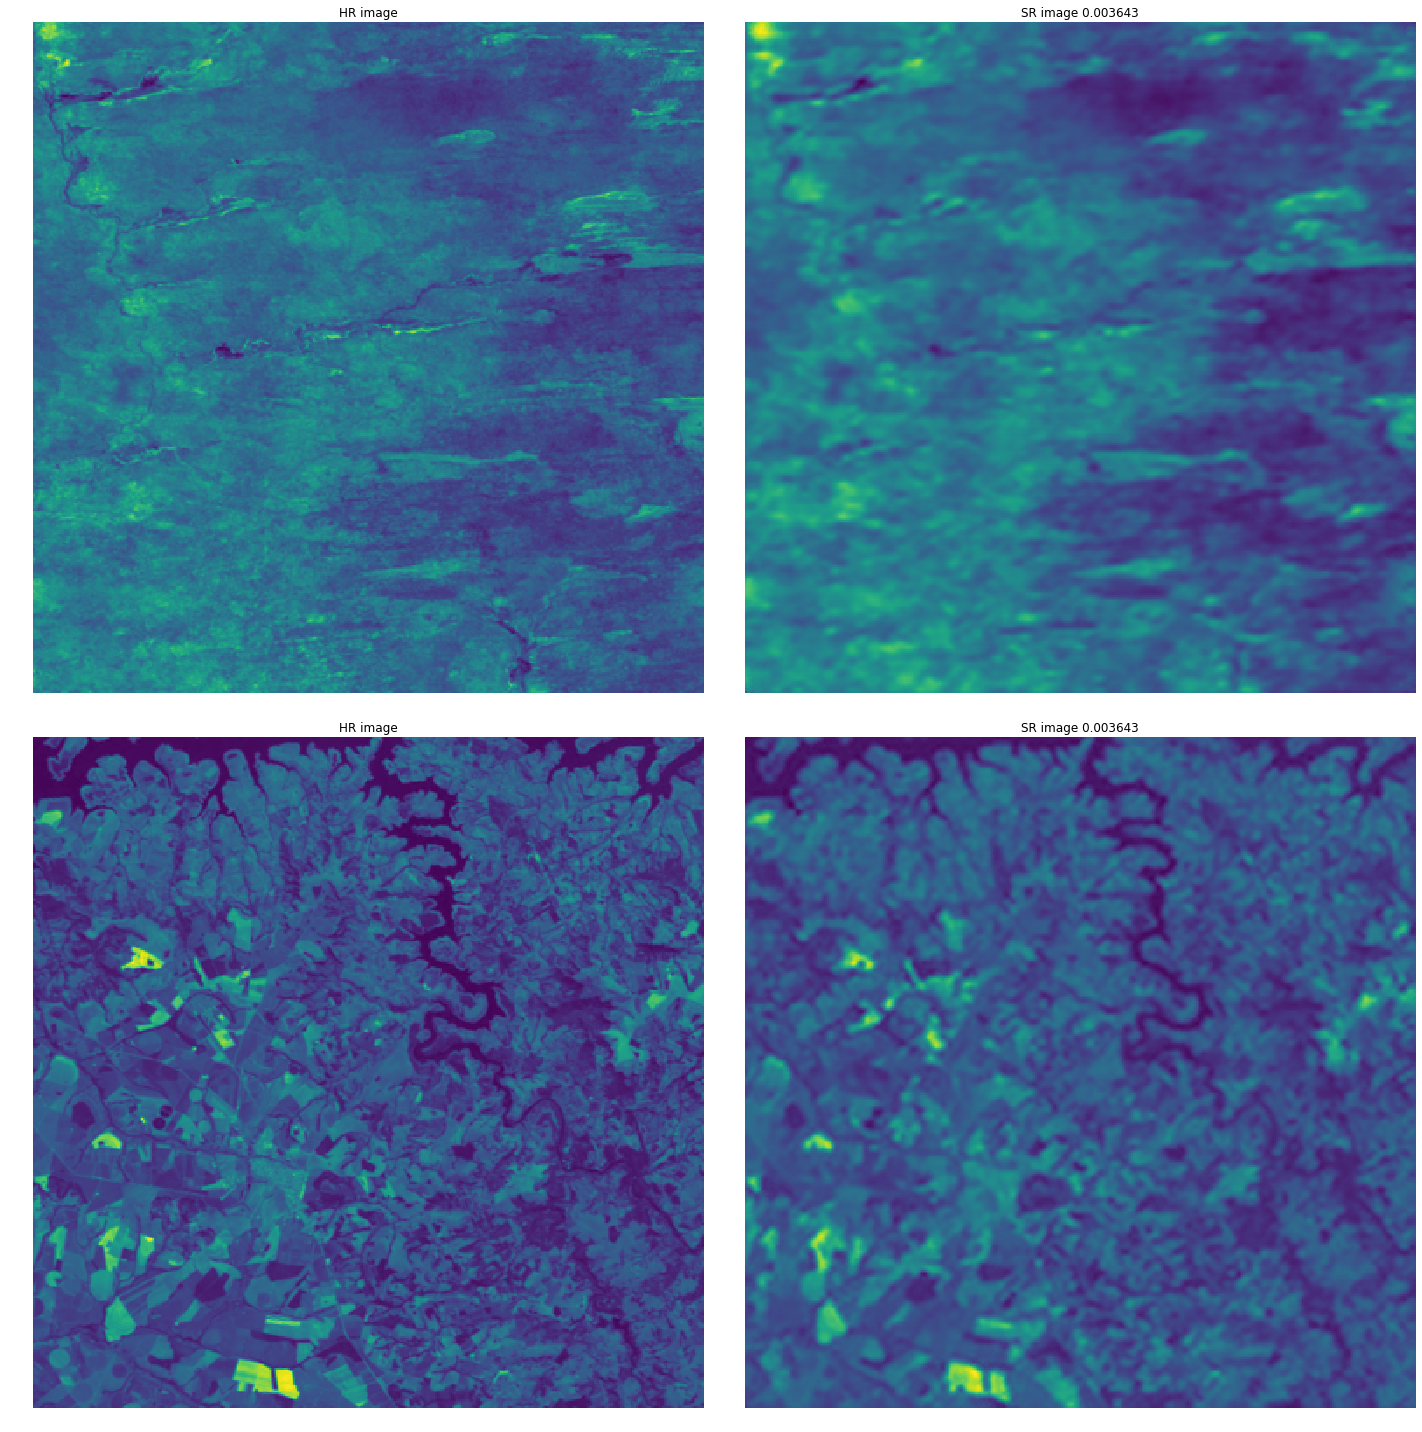

In [63]:
batch_data = DataGeneratorV1(list_paths = train_folds, batch_size= 2, **lapsrn_generator_params)
lr_img, hr_img = batch_data[0]
sr_image = model.predict(lr_img)
fig = plt.figure(figsize=(20, 20))
for i in range(2):
    ax = fig.add_subplot(2, 2, i*2+1); ax.imshow(hr_img[i,:,:,0]); ax.set_title('HR image'); plt.axis('off')
    ax = fig.add_subplot(2, 2, i*2+2); ax.imshow(sr_image[i, :,:,0]); ax.set_title('SR image {:.6f}'.format(np.mean(np.square(hr_image - sr_image))));
    plt.axis('off')
fig.tight_layout()
fig.show()    